In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import jv
from functools import reduce
from matplotlib.ticker import FormatStrFormatter
import pandas as pd
import scipy.integrate as integrate

#Check if all libraries are installed, otherwise use !pip install

In [2]:
#PROPERTIES OF THE MATERIALS

freq = np.arange(50, 20000, 10)   #Frequency vetor
omega = 2*np.pi*freq  #Angular velocity vector

#Porous material properties
c1 = 450
rho1 = 1700
z1 = rho1*c1
d = 15e-3   #Thickness of core material [m]
Np = 0.71          #Prandlt number for air

phi = 0.5357;          #x(1)  Porosity
alpha_inf = 1.5098;   #%x(2)  Tortuosity
sigma = 10247;       #%x(3)  [Ns/m^4] flow resistivity
r_por = 0.22;         #%x(4) std dev of size pore
lamb = 1.28e-4;          #%x(4)  [um]  Viscous characteristic length    
lamb_prima = 2.56e-4;   #%x(5)  [um]   Thermal characteristic length  
#YMgruesa:    ϕ     α_∞     σ      Λ    Λ'
           #0.5357 1.5098  10247 1.28e-04 2.56e-04

#Properties for air
Pr = 0.71  #Prandtl number
rho0 = 1.204  #Density of air [kg/m^3]
c0 = 343  #Speed of sound[m/s]
z0 = rho0*c0  #[Rayl] Characteristic Impedance
gamma = 1.4   #Specific heat ratio
P0 =  101325 #Static pressure [Pa]
nu =  1.81e-5  #Viscosity of air [kg/m.s] 
l = 7e-3 #[m] air cavity thickness (core)

#Rigid material properties
#Example
l_beam = 0.760  #[m] Beam length
h = 3e-3 #[m] Thickness sandwich laminate
height_beam = 55e-3  #[m]

h_single = 12e-3  #[m] Thickness of equivalent homogeneuos panel
rho = 442  #[kg/m^3] Density
Bmod = 5.5  #[Nm]
Emod = (Bmod)/((h_single**3 * height_beam)/12)
#Emod = 4.7e7  #[Pa] Young modulus
v = 0.3  #Poisson ratio
nu_mat = 0.007   #Loss factor [Pa/s]

#glass reference
#h_single = 8e-3
#rho = 2440
#Emod = 71e9

Emod*1e-6


694.4444444444445

In [3]:
#DEFINITIONS


#Dynamic bulk modulus and density for porous material (JCA model)

def dens_JCA(phi, alpha_inf, sigma, lamb, nu, rho0, omega):
    G2 = ((4*1j*(alpha_inf**2)*nu*rho0)*omega) / ((sigma**2) * (lamb**2)*(phi**2))
    d_JCA = (alpha_inf*rho0/phi) + (sigma / (1j*omega)) * np.sqrt(1 + G2)
    return d_JCA

def bulk_JCA(phi, lamb_prima, P0, Np, gamma, nu, rho0, omega):
    G1prima = 8*nu / (rho0*omega*Np*lamb_prima**2)
    G2prima = rho0*omega*Np*lamb_prima**2 / (16*nu)
    B_JCA = (gamma*P0/phi) / (gamma - (gamma - 1)*(1 + (G1prima/1j) * np.sqrt(1 + (1j*G2prima)))**(-1))
    return B_JCA


#-------------------------------------------------------------------------------
#Impedance for infinite elastic wall

def z_wall(omega, hi, rho, E, v, nu_mat, theta):
    """_Calculates the acoustic impedance of a single wall_

    Args:
        omega (_float_): _Angular frequency_
        h (_type_): _Thickness of the wall_
        rho (_type_): _Density of the wall_
        E (_type_): _Young modulus_
        v (_type_): _Poisson ratio_
        nu_mat (_type_): _Loss factor_
        theta (_type_): _Angle of incidence of the wave_

    Returns:
        _type_: _description_
    """
    theta_rad = theta * (np.pi/180)   #from degree to radians
    #Zw = (D/1j*omega) * ((k0**4) * (np.sin(theta)**4) - kw**4)
    #k0 = omega/c0    #Wavenumber of surrounding medium
    
    ms = rho*hi   #Surface mass density
    Bwall = (E * (hi**3)) / (12*(1 - v**2))   #Bending stiffness
    #cw = (omega**2 * D/ms)**(1/4)
    #kw = omega/cw
    f = omega/(2*np.pi)

    fco = (c0**2 / (2 * np.pi * np.sin(theta_rad))) * np.sqrt(ms/Bwall)   #Coincidence frequency
    fcr =  (c0**2 / (2 * np.pi )) * np.sqrt(ms/Bwall)          #Critical frequency
    Zw = 1j*ms*(omega) * (1 - ((f)/fcr)**2 * (1 + 1j*nu_mat) * (np.sin(theta_rad)**4)) 
    
    return Bwall, fcr, Zw

#-------------------------------------------------------------------------------

#Transfer matrix for elastic wall
def TM_wall(omega, hi, rho, E, v, nu_mat, theta):
    #Sn = np.pi*(r**2)
    TM_wall = []
    if np.array(omega).size > 1:
        for omg in omega: 
            Bwall, fcr, zw = z_wall(omg, hi, rho, E, v, nu_mat, theta)
            TM_w = np.matrix([[1 , zw],
                            [0 , 1]])
            TM_wall.append(np.array(TM_w))
        return fcr, np.array(TM_wall)
    
    else:
        Bwall, fcr, zw = z_wall(omega, hi, rho, E, v, nu_mat, theta)
        TM_w = np.matrix([[1 , zw],
                        [0 , 1]])
        TM_wall.append(np.array(TM_w))
        return fcr, np.array(TM_wall)
    
    
#Transfer matrix for porous material or air
def TM_poro(omega, D_poro, B_poro, l, theta = 0):
    """_summary_

    Args:
        keff (_int/float_): _wavenumber_(vector array)
        l (_int_): _lenght of the material layer_
        Zc (_int/float/complex_): _acoustic impedance_(it could be a single number or array complex)

    Returns:
        _type_: _description_
    """
    Zc = np.sqrt(D_poro*B_poro)  #Characteristic impedance
    keff = omega*np.sqrt(D_poro/B_poro)
    
    TM_p = []
    theta = theta*(np.pi/180)
    if np.array(Zc).size > 1:
        for k, z in zip(keff, Zc):
            kz= np.sqrt(k**2 - k**2 * np.sin(theta)**2)
            TMi = np.matrix([[np.cos(kz*l), 1j*(z)*(k/kz)*np.sin(kz*l)],
                           [1j*(1/z)*(kz/k)*np.sin(kz*l), np.cos(kz*l)]])
            TM_p.append(TMi)
    elif np.array(keff).size > 1:
        for k in keff:
            kz = np.sqrt(k**2 - k**2 * np.sin(theta)**2)
            TMi = np.matrix([[np.cos(kz*l), 1j*(Zc)*(k/kz)*np.sin(kz*l)],
                        [1j*(1/Zc)*(kz/k)*np.sin(kz*l), np.cos(kz*l)]])
            TM_p.append(TMi)
    else:
        k = keff
        kz = np.sqrt(k**2 - k**2 * np.sin(theta)**2)
        TMi = np.matrix([[np.cos(kz*l), 1j*(Zc)*(k/kz)*np.sin(kz*l)],
                    [1j*(1/Zc)*(kz/k)*np.sin(kz*l), np.cos(kz*l)]])
        TM_p.append(TMi)
    return np.array(TM_p)



<h1 style='font-size:25px'><center>Impedance of an infinite single wall</center></h1>
<img src="imag3.png" alt="Drawing" style="width: 30%; display: block; margin-left: auto; margin-right: auto;"/>

$Z_{\mathrm{w}}=i m^{\prime}\omega\left[1-\left(\frac{f}{f_{c}}\right)^{2}(1+i\eta_{\mathrm{w}})\sin^{4}\theta\right].$

$f_{c}^{\prime}=\frac{c_{0}^{2}}{2\pi\sin\theta}\sqrt{\frac{m^{\prime}}{D}}.$

$f_{c}=\frac{c_{0}^{2}}{2\pi}\sqrt{\frac{m^{\prime}}{D}}=f_{c}^{\prime}\sin\theta.$

4113.683034360097 109.89010989010991
4113.683034360097 109.89010989010991
4113.683034360097 109.89010989010991
4113.683034360097 109.89010989010991
4113.683034360097 109.89010989010991
4113.683034360097 109.89010989010991
4113.683034360097 109.89010989010991


Text(0.5, 0.98, 'Acoustic Impedance')

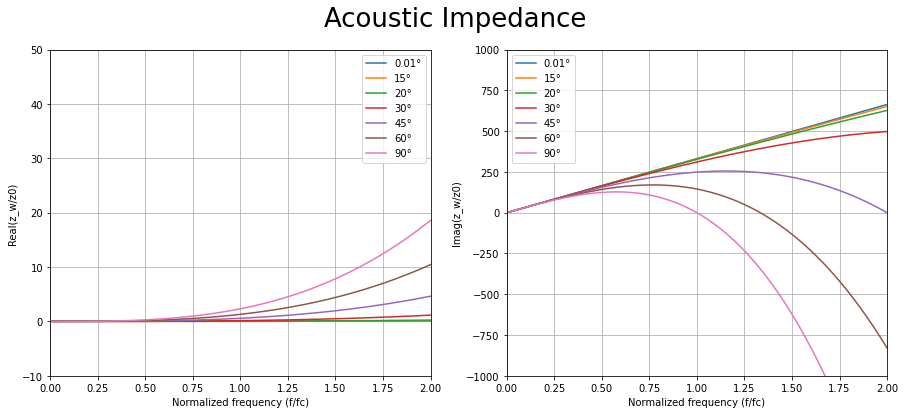

In [14]:
#Impedance plot forfor single elastic wall of thickness h

thetas = [0.01, 15, 20, 30, 45, 60, 90]
#thetas_rad = [theta*(np.pi/180) for theta in thetas]

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6), sharey=False)

for theta in thetas:
    Bwall, fc, z_w = z_wall(omega, h_single, rho, Emod, v, nu_mat, theta=theta)
    
    ax1.plot(freq/fc, np.real(z_w/z0), label=f'{theta}°')
    ax1.legend()
    ax1.set_ylabel('Real(z_w/z0)')
    ax1.set_xlabel('Normalized frequency (f/fc)')
    ax1.set_xlim([0, 2])
    ax1.set_ylim([-10, 50])
    
    
    ax2.plot(omega/(2*np.pi*fc), np.imag(z_w/(1*z0)), label=f'{theta}°')
    ax2.legend()
    ax2.set_ylabel('Imag(z_w/z0)')
    ax2.set_xlabel('Normalized frequency (f/fc)')
    ax2.set_ylim([-1000, 1000])
    ax2.set_xlim([0, 2])
    
    #print(fc, Bwall)
    
ax1.grid(which='major')
ax2.grid(which='major')
f.suptitle('Acoustic Impedance', fontsize=26)


## Transmission coeficcient from the transfer matrix

### Transfer matrix for sandwich wall with porous soft core
$T=\left[\begin{array}{c}{{1\;Z_{1}}}\\ {{0\;\;1}}\end{array}\right]\left[\begin{array}{c c}{{\cos(k_{0,z}L)}}&{{i Z_{0}\frac{k_{0}}{k_{0,z}}\sin(k_{0,z}L)}}\\ {{\frac{i}{Z_{0}}\frac{k_{0,z}}\sin(k_{0,z}L)}}&{{\cos(k_{0,z}L)}}\end{array}\right]\left[\begin{array}{c}{{1\;Z_{2}}}\\ {{0\;\;1}}\end{array}\right]$


with $k_{0,z}=\sqrt{k_{0}^{2}-k_{0}^{2}\sin^{2}(\theta)}$,

### Transfer matrix for wall with several rigid layers
$T=\left[\begin{array}{c}{{1\;Z_{1}}}\\ {{0\;\;1}}\end{array}\right]\left[\begin{array}{c}{{1\;Z_{2}}}\\ {{0\;\;1}}\end{array}\right]...\left[\begin{array}{c}{{1\;Z_{n}}}\\ {{0\;\;1}}\end{array}\right]$

The transmission coefficient can be calculated as:

$\tau(\omega,\theta)=\frac{2}{T_{11}+T_{12}\cos(\theta)/Z_{0}+T_{22}+T_{21}Z_{0}/\cos(\theta)}$

The transmission loss is:

$T L=-10\log_{10}|\tau|^{2},$

In [5]:
#Sound transmission for a double wall partition with air or porous material core

angle_inc = 0.01

#Porous material (JCA model)
D_poro = dens_JCA(phi, alpha_inf, sigma, lamb, nu, rho0, omega)
B_poro = bulk_JCA(phi, lamb_prima, P0, Np, gamma, nu, rho0, omega)

Zc_poro = np.sqrt(D_poro*B_poro)  #Characteristic impedance
k_poro = omega*np.sqrt(D_poro/B_poro)
#TM_poromat= TM_poro(k_poro, l, Zc_poro)
TM_poromat = TM_poro(omega, D_poro, B_poro, l, angle_inc)

Z_poro = -1j*Zc_poro*(1/np.tan(k_poro*d)) #Surface impedance
alpha_JCAL = 1 - np.abs((Z_poro - z0) / (Z_poro + z0))**2

#Air
d_air = rho0
B_air = rho0 * c0**2
TM_air = TM_poro(omega, d_air, B_air, l, angle_inc)

fc, TM_w = TM_wall(omega, h, rho, Emod, v, nu_mat, angle_inc)
fc, TM_homo_wall = TM_wall(omega, h_single, rho, Emod, v, nu_mat, angle_inc)

#Total transfer matrix for different cases
TL_sand_air = []
TL_sand_poro = []
TL_homo_wall = []
for i in range(len(freq)):
    k0_i = omega[i]/c0
    #Sandwich with air
    TM_tot_air = reduce(np.dot, [TM_w[i], TM_air[i], TM_w[i]])
    t_sand_air = np.abs((2*np.exp(1j*k0_i*l))/(TM_tot_air[0][0] + (TM_tot_air[0][1]*np.cos(angle_inc*(np.pi/180)))/z0 + TM_tot_air[1][0]*z0/np.cos(angle_inc*(np.pi/180)) + TM_tot_air[1][1]))
    TL_sand_air.append(-20*np.log10(t_sand_air))
    
    #Sandwich with porous material (YM)
    TM_tot_poro = reduce(np.dot, [TM_w[i], TM_poromat[i], TM_w[i]])
    t_sand_poro = np.abs((2*np.exp(1j*k0_i*l))/(TM_tot_poro[0][0] + (TM_tot_poro[0][1]*np.cos(angle_inc*(np.pi/180)))/z0 + TM_tot_poro[1][0]*z0/np.cos(angle_inc*(np.pi/180)) + TM_tot_poro[1][1]))
    TL_sand_poro.append(-20*np.log10(t_sand_poro))
    
    #Single homogeneous wall
    #TM_tot_wall = reduce(np.dot, [TM_homo_wall[i], TM_homo_wall[i]])
    TM_tot_wall = TM_homo_wall[i]
    t_homo_wall = np.abs((2*np.exp(1j*k0_i*l))/(TM_tot_wall[0][0] + (TM_tot_wall[0][1]*np.cos(angle_inc*(np.pi/180)))/z0 + TM_tot_wall[1][0]*z0/np.cos(angle_inc*(np.pi/180)) + TM_tot_wall[1][1]))
    TL_homo_wall.append(-20*np.log10(t_homo_wall))


## Integration of tau: TL for diffuse incidence

$\tau_{\mathrm{NR,Q}}=\frac{\displaystyle\int_{0}^{\pi/2}\tau_{\theta}\cos\theta\sin\theta\,\mathrm{d}\theta}{\displaystyle\int_{0}^{\pi/2}\cos\theta\sin\theta\,\mathrm{d}\theta}=\int_{0}^{\pi/2}\tau_{\theta}\sin2\theta\,\mathrm{d}\theta$

In [6]:
#Integration TL over the angles for diffuse field

#Single wall
f_coinc = []
f_coinc_sand = []

def integrand(theta, fi):
    #calculate transmission index for i-th freq over the angle range of incidence
    omg = fi*2*np.pi
    t_wall_angle_i = []
    theta_deg = theta * (180/np.pi)
    fc, TM_homo_wall2 = TM_wall(omg, h_single, rho, Emod, v, nu_mat, theta_deg)
    f_coinc.append(fc)
    
    #theta_rad = theta*(np.pi/180)
    theta_rad = theta
    #Single homogeneous wall
    TM_tot_wall2 = TM_homo_wall2[0]
    #print(TM_tot_wall2)
    t_homo_wall = np.abs((2) / (TM_tot_wall2[0][0] + (TM_tot_wall2[0][1]*np.cos(theta_rad))/z0 + TM_tot_wall2[1][0]/(np.cos(theta_rad)*z0) + TM_tot_wall2[1][1]))
    #t_wall_angle_i = (t_homo_wall*np.sin(2*theta_rad))
    t_wall_angle_i = 2*(t_homo_wall*np.cos(theta_rad)*np.sin(theta_rad))#/(np.sin(theta_rad)*np.cos(theta_rad))
    #t_wall_angle_i.append(t_homo_wall_i)
    return t_wall_angle_i

#Sandwich wall
def integrand2(theta, fi):
    #calculate transmission index for i-th freq over the angle range of incidence
    omg = fi*2*np.pi
    t_wall_angle_i = []
    theta_deg = theta * (180/np.pi)
    fcs, TM_homo_wall2 = TM_wall(omg, h, rho, Emod, v, nu_mat, theta_deg)
    f_coinc_sand.append(fcs)
    
    D_po = dens_JCA(phi, alpha_inf, sigma, lamb, nu, rho0, omg)
    B_po = bulk_JCA(phi, lamb_prima, P0, Np, gamma, nu, rho0, omg)
    TM_poro_mat= TM_poro(omg, D_po, B_po, l, theta_deg)
    
    #theta_rad = theta*(np.pi/180)
    theta_rad = theta
    #Sandwich TM
    TM_tot_wall2 = reduce(np.dot, [TM_homo_wall2[0], TM_poro_mat[0], TM_homo_wall2[0]])
    #print(TM_tot_wall2)
    t_homo_wall = np.abs((2*np.exp(1j*k0_i*l))/(TM_tot_wall2[0][0] + (TM_tot_wall2[0][1]*np.cos(theta_rad))/z0 + (TM_tot_wall2[1][0]*z0)/(np.cos(theta_rad)) + TM_tot_wall2[1][1]))
    t_wall_angle_i = (t_homo_wall*np.sin(2*theta_rad))
 
    return t_wall_angle_i

#Integration

TL_diff=[]
TL_diff_sand=[]
for i, fi in enumerate(freq):
    #Integration for single inf wall
    t_f_i, err = integrate.quad(integrand, 0, 80*(np.pi/180), args=(fi,))
    TL_f_i = -20 * np.log10(t_f_i)
    TL_diff.append(TL_f_i)
    
    #Integration for sandwich
    #t_f_i_s, err = integrate.quad(integrand2, 0.01, np.pi/2, args=(fi,))
    #TL_f_i_s = -20*np.log10(t_f_i_s)
    #TL_diff_sand.append(TL_f_i_s)

In [7]:
#SAVE THE TL DATA AS A DATAFRAME

d = {'freq': list(freq), 'TL_': TL_diff}
df_TL_diff = pd.DataFrame(data=d)
#df_TL_diff.to_csv('TMM_TL_paper_sand.csv', index=False)
df_TL_diff.head()

,freq,TL_
0,50,4.645047
1,60,5.618668
2,70,6.521684
3,80,7.358150
4,90,8.134228


Text(5300, 5, ' f₃')

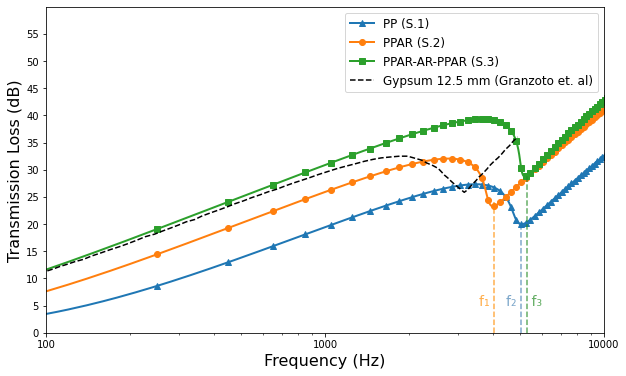

In [8]:
#Measured data from the beams:
df_TL = pd.read_csv('TL_beams_meas.csv')
df_TLglass = pd.read_csv('TL_glass_reference2.csv')
df_TL_paper = pd.read_csv('TMM_TL_paper.csv')  #Sample 1
df_TL_paperYM = pd.read_csv('TMM_TL_paperYM.csv')   #Sample 2
df_TL_paper_sand = pd.read_csv('TMM_TL_paper_sand.csv')   #Sample 3

#TL gypsum 12.5 mm Granzoto et al.
x_gypsum = [101.17578987583981, 106.43273422582055, 111.9628216264531, 118.24006276340594, 126.83066605574767, 136.04541029661073, 145.9296417684816, 157.75660096061821, 169.87886986240972, 182.93263324641327, 195.46032039411924, 210.479803249479, 226.65340712944152, 245.02267443108693, 261.80244387349205, 280.82341598497464, 298.8880399791588, 318.11471322378236, 341.226992081675, 361.7648736893312, 388.04850752998385, 417.86677393895457, 448.22643038757343, 475.20442912255936, 509.72989061122706, 544.6374764590192, 584.2075205629665, 626.6524832284654, 672.181238540008, 723.8327173035202, 773.4026035984252, 826.3671604692114, 886.4059686658436, 947.1092803945206, 1019.8866685127568, 1106.8483961931888, 1187.2652638287086, 1278.4966208575083, 1382.1131800357693, 1488.3169618051675, 1590.2406532933016, 1705.7778601631296, 1851.2228339415653, 1977.999232951086, 2080.7731465986976, 2223.2697287739684, 2320.632488607679, 2441.20911928522, 2548.1160114668996, 2618.5725154751335, 2680.5123494249697, 2765.383848696759, 2830.7963646318985, 2920.4262190330464, 2989.5061142815584, 3060.22002852923, 3157.1139906027647, 3257.075849689842, 3360.2027428244382, 3480.128601608084, 3562.4477225924297, 3689.5917181195064, 3806.413108957252, 3911.662069075768, 4035.5147439266334, 4179.542532825066, 4311.8769505744085, 4431.10220338237, 4589.248534949275, 4734.555234907424, 4903.531825298401]
y_gypsum = [11.39240506329114, 11.761603375527427, 12.183544303797468, 12.552742616033756, 13.080168776371309, 13.50210970464135, 14.135021097046414, 14.715189873417723, 15.29535864978903, 15.822784810126583, 16.350210970464136, 16.9831223628692, 17.668776371308017, 18.143459915611814, 18.723628691983123, 19.303797468354432, 19.831223628691983, 20.411392405063292, 20.833333333333332, 21.4662447257384, 22.046413502109704, 22.626582278481013, 23.206751054852322, 23.734177215189874, 24.261603375527425, 24.841772151898734, 25.36919831223629, 25.949367088607595, 26.424050632911392, 27.056962025316455, 27.58438818565401, 28.059071729957807, 28.58649789029536, 29.113924050632914, 29.641350210970465, 30.221518987341774, 30.643459915611814, 31.065400843881857, 31.540084388185655, 31.90928270042194, 32.17299578059072, 32.33122362869199, 32.48945147679325, 32.48945147679325, 32.17299578059072, 31.751054852320674, 31.223628691983123, 30.748945147679326, 30.221518987341774, 29.58860759493671, 29.008438818565402, 28.428270042194093, 27.90084388185654, 27.26793248945148, 26.845991561181435, 26.424050632911392, 25.843881856540087, 26.371308016877638, 27.21518987341772, 28.00632911392405, 28.639240506329113, 29.377637130801688, 30.116033755274263, 30.854430379746837, 31.540084388185655, 32.22573839662447, 32.96413502109705, 33.70253164556962, 34.44092827004219, 35.28481012658228, 36.02320675105485]


linewidth=2
#Plot TL
f, (axs) = plt.subplots(1, 1, figsize=(10, 6), sharey=True)
#axs.semilogx(freq, TL_sand_air, label=f'TMM sandwich air core')
#axs.semilogx(freq, TL_sand_poro, linestyle=':', label=f'TMM sandwich (normal incidence)')
#axs.semilogx(freq, TL_homo_wall,':' ,label=f'TMM single wall (normal incidence)')

#axs.semilogx(df_TL['frequency'], df_TL['TL_YM_paper'],'-',  linewidth=linewidth, label=f'PPAR sample')
#axs.semilogx(df_TL['frequency'], df_TL['TL_paper'],'-',  linewidth=linewidth, label=f'PP sample')
#axs.semilogx(df_TL['frequency'], df_TL['TL_sandwich'],'-',  linewidth=linewidth, label=f'PPAR-AR-PPAR sample')

#axs.semilogx(df_TLglass['freq'], df_TLglass['tl'],'-', linewidth=linewidth, label=f'TL glass 8 mm (A. Panteghini, A. Feriani, E.A. Piana et al.)')

#axs.semilogx(freq, TL_diff,'--', label=f'Predicted by TMM')
#axs.semilogx(freq, TL_diff_sand,'--' ,label=f'TMM TL sandwich difuse field')

axs.semilogx(df_TL_paper['freq'], df_TL_paper['TL_'],'-', marker='^', markevery=20, linewidth=linewidth, label=f'PP (S.1)')
axs.semilogx(df_TL_paperYM['freq'], df_TL_paperYM['TL_'],'-', marker='o', markevery=20, linewidth=linewidth, label=f'PPAR (S.2)')
axs.semilogx(df_TL_paper_sand['freq'], df_TL_paper_sand['TL_'],'-', marker='s', markevery=20, linewidth=linewidth, label=f'PPAR-AR-PPAR (S.3)')
axs.semilogx(x_gypsum, y_gypsum, '--', c='black', label='Gypsum 12.5 mm (Granzoto et. al)')   #Gypsum 12.5 mm

axs.legend(fontsize=12)
#axs.set_title('TL for normal incidence')
axs.grid(which='minor', linestyle='--', linewidth=1, alpha=0.2)
axs.grid(which='major', linestyle='-', linewidth=1, alpha=0.6)
axs.set_ylabel('Transmission Loss (dB)', fontsize=16)
axs.set_xlabel('Frequency (Hz)', fontsize=16)
axs.set_xlim([100, 10000])
ylim=60
axs.set_ylim([0, ylim])
axs.set_yticks(np.arange(0, ylim, 5)) 
axs.xaxis.set_major_formatter(FormatStrFormatter('%.0f'))
axs.grid(which='minor', color='#999991', linestyle='-', alpha=0.2) 
axs.grid(which='major', axis='both',color='#999999', alpha=0.2)
transparency= 0.7
axs.axvline(x=5050, ymin=0, ymax=0.32, linestyle='--', color='steelblue', alpha=transparency)
axs.axvline(x=4050, ymin=0, ymax=0.4, linestyle='--', color='darkorange', alpha=transparency)
axs.axvline(x=5300, ymin=0, ymax=0.48, linestyle='--', color='forestgreen', alpha=transparency)
axs.text(4050, 5, u'f\u2081 ', fontsize=14, color='darkorange', horizontalalignment='right', alpha=transparency)
axs.text(5050, 5, u'f\u2082 ', fontsize=14, color='steelblue', horizontalalignment='right',alpha=transparency)
axs.text(5300, 5, u' f\u2083', fontsize=14, color='forestgreen', horizontalalignment='left', alpha=transparency)


#f.savefig('TL_infinite_walls.png', bbox_inches='tight')




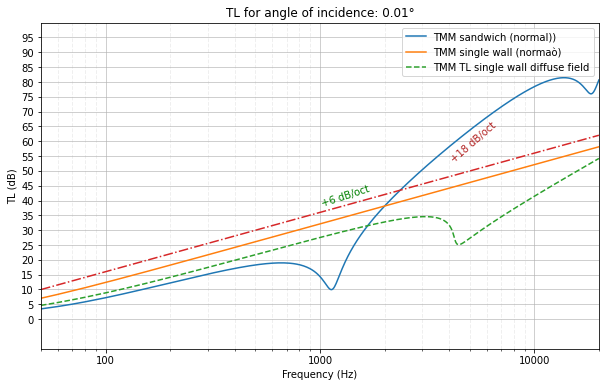

In [9]:
#This part is just to test theoretical TL of single wall and doble wall with air/porous material (soft) core (sandwich)
#Using TMM based on acoustic impedance of layers

fcut = 3800
slope6 = 20*np.log10(freq[:fcut]) - 24
slope18 = 60*np.log10(freq[fcut:]) - 167.3
slope24 = 24*np.log10(freq[fcut:]) - 92

#Plot TL
f, (axs) = plt.subplots(1, 1, figsize=(10, 6), sharey=True)
#axs.semilogx(freq, TL_sand_air, label=f'TMM sandwich air core')
axs.semilogx(freq, TL_sand_poro, label=f'TMM sandwich (normal))')
axs.semilogx(freq, TL_homo_wall,'-' ,label=f'TMM single wall (normal)')
axs.semilogx(freq, TL_diff,'--' ,label=f'TMM TL single wall diffuse field')
#axs.semilogx(freq, TL_diff_sand,'--' ,label=f'TMM TL sandwich diffuse field')

axs.semilogx(freq[:fcut], slope6,'-.')
axs.semilogx(freq[fcut:], slope18,'-.')
axs.text(1000, 38, '+6 dB/oct', rotation=18, color='g')
axs.text(4000, 53, '+18 dB/oct', rotation=41, color='firebrick')

#axs.semilogx(df_TL['frequency'], df_TL['TL_YM_paper'],'--' ,label=f'paper+YM meas')
#axs.semilogx(df_TL['frequency'], df_TL['TL_paper'],'--' ,label=f'paper meas')
#axs.semilogx(df_TL['frequency'], df_TL['TL_sandwich'],'--' ,label=f'sandwich (paper-YM-paper) meas')
axs.legend()
axs.set_title(f'TL for angle of incidence: {angle_inc}°')
axs.grid(which='minor', linestyle='--', linewidth=1, alpha=0.2)
axs.grid(which='major', linestyle='-', linewidth=1, alpha=0.6)
axs.set_ylabel('TL (dB)')
axs.set_xlabel('Frequency (Hz)')
axs.set_xlim([50, 20000])
ylim=100
axs.set_ylim([-10, ylim])
axs.set_yticks(np.arange(0, ylim, 5)) 
axs.xaxis.set_major_formatter(FormatStrFormatter('%.0f'))

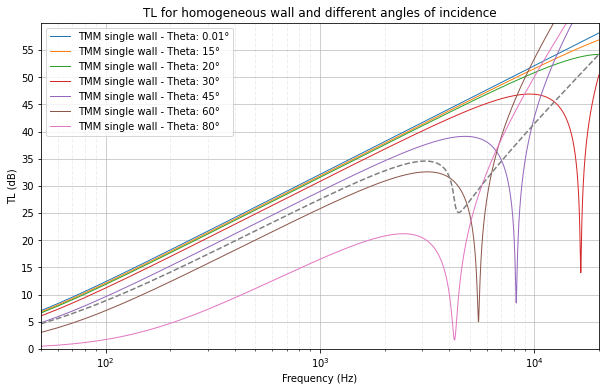

4113.683034360097

In [15]:
#TL as a function of angle of incidence (TMM)

angle_inc = [0.01, 15, 20, 30, 45, 60, 80]

for theta in angle_inc:
    TL_homo_wall2 = []
    theta_rad = theta * (np.pi/180)
    fc, TM_homo_wall2 = TM_wall(omega, h_single, rho, Emod, v, nu_mat, theta)
    #print(fc)                #Coincidence frequency
    for i in range(len(freq)):
        
        #Single homogeneous wall
        TM_tot_wall2 = TM_homo_wall2[i]
        #t_homo_wall2 = np.abs((2)) / (TM_tot_wall2[0][0] + TM_tot_wall2[0][1]/z0 + TM_tot_wall2[1][0]*z0 + TM_tot_wall2[1][1]))
        t_homo_wall2 = np.abs((2) / (TM_tot_wall2[0][0] + (TM_tot_wall2[0][1]*np.cos(theta_rad))/z0 + (TM_tot_wall2[1][0]*z0)/(np.cos(theta_rad)) + TM_tot_wall2[1][1]))
        TL_homo_wall2.append(-20*np.log10(t_homo_wall2))
    
    plt.figure(1, figsize=(10, 6))
    ax = plt.gca()
    ax.semilogx(freq, TL_homo_wall2,'-', linewidth=1 ,label=f'TMM single wall - Theta: {theta}°')
    ax.legend()
    ax.set_title(f'TL for homogeneous wall and different angles of incidence')
    ax.grid(which='minor', linestyle='--', linewidth=1, alpha=0.2)
    ax.grid(which='major', linestyle='-', linewidth=1, alpha=0.6)
    ax.set_ylabel('TL (dB)')
    ax.set_xlabel('Frequency (Hz)')
    ax.set_xlim([50, 20000])
    ylim=60
    ax.set_ylim([0, ylim])
    ax.set_yticks(np.arange(0, ylim, 5)) 
    ax.xaxis.set_major_formatter(FormatStrFormatter('%.0f'))

ax.semilogx(freq, TL_diff, '--', label=f'TMM TL single wall diffuse field')
plt.show()
fc